# Run BACCARAT

This is a notebook designed to run on BACCARAT sourced from cvmfs on cori.
It is designed to compliment the slides in this git repo.
Use the kernel `pyROOT` on cori, or your own conda environment (which has ROOT installed).

This is designed to be an easy introduction with everything contained in this repository.
It is recommended that you try out these commands outside of this notebook so that you have familiarity with `bash`
and you download and explore (using ROOT) the simulation outputs on your local machine.

After running this tutorial, you should look at the [gitlab BACCARAT tutorial](https://luxzeplin.gitlab.io/docs/softwaredocs/simulations/baccarat/tutorials/Tuto1.html), however as it requires knowledge of C++ and is less readable it's recommended that you start with this python notebook.
It is worthwise looking at though to see how to build BACCARAT locally.

## S2 photons

The simplest simulation which can be performed is an S2 photon bomb.
This is a scintillation light produced when electrons pass through the gaseous Xenon.
It is the most simple because no other interactions happen; the photons are produced, they bounce around the detector
until they are absorbed (either by PMTs - resulting in a detection - or, by another surface).

Be sure to look at the macro `macros/s2photonbomb.mac` as it contains information about what we are trying to run here.

In [12]:
%%script env bash

# shifter is a cori spesific thing, on other systems this wont be required. It's basically a container which you run things in.
shifter --module=cvmfs --image=luxzeplin/offline_hosted:centos7 /bin/bash
    
# macro defining the simulation parameters for BACCARAT    
macro=macros/s2photonbomb.mac
export OUTDIR=bacc_outdir
export NEVENTS=10000
export SEED=42

# version of BACCARAT to use
BACCARAT_release=6.0.0

# Set up the enviroment for BACCARAT
source /cvmfs/lz.opensciencegrid.org/BACCARAT/release-${BACCARAT_release}/x86_64-centos7-gcc8-opt/setup.sh

# make a directory for the BACCARAT output
mkdir -p bacc_outdir

# Run BACCARAT with the macro defined above. 
# The &> is to supress the output and keep the notebook tidy. I suggest running this in the terminal directly as well to get an idea of what BACCARAT is actually doing.
# In that case, remove &> bacc_outdir/s2photonbomb.log
echo "Running BACCARAT"
BACCARATExecutable ${macro} &> bacc_outdir/s2photonbomb.log

echo "Running ROOT Converter"
BaccRootConverter ${OUTDIR}/s2photonbomb_${SEED}.bin

Running BACCARAT
Running ROOT Converter
Processing 0 of 20350
Processing 10000 of 20350
Processing 20000 of 20350
Done in 0.64 s.


Lets now look at the result of the output of the simulation and see what happened.
All of the functions needed to view the ROOT file are in `viewer.py`.

First, lets look at what is in the file;
There are two parts `Header` and `Data`. The `Header` contains the general information about the file such as number of events, the runID, etc... The `Data` contains the information about each event including; particle interactions / decays etc...

In [13]:
import viewer
viewer.view_baccarat_contents('bacc_outdir/s2photonbomb_42.root')

TFile**		bacc_outdir/s2photonbomb_42.root	
 TFile*		bacc_outdir/s2photonbomb_42.root	
  KEY: TTree	HeaderTree;1	Header tree
  KEY: TTree	DataTree;1	Data tree
******************************************************************************
*Tree    :DataTree  : Data tree                                              *
*Entries :    10000 : Total =         5699942 bytes  File  Size =    1891477 *
*        :          : Tree compression factor =   3.01                       *
******************************************************************************
*Branch  :Event                                                              *
*Entries :    10000 : BranchElement (see below)                              *
*............................................................................*
*Br    0 :fUniqueID : UInt_t                                                 *
*Entries :    10000 : Total  Size=      40665 bytes  File Size  =        400 *
*Baskets :        2 : Basket Size=      32000 bytes 

As we can see there are a lot of information.
It's broken down into two levels;
* primaries
    - what was initially put in
* tracks
    - the information of the particle propagation
    - what happened in each step of the event

To understand these better, you should download the file and explore it in the TBrowser.

Lets look at the simpliest information about the primary particles;
Namely, the;
* primary particle energy
* primary particle Y-position

These are shown below.
All these of these are defined from the macro and you can see that they match what is defined there.

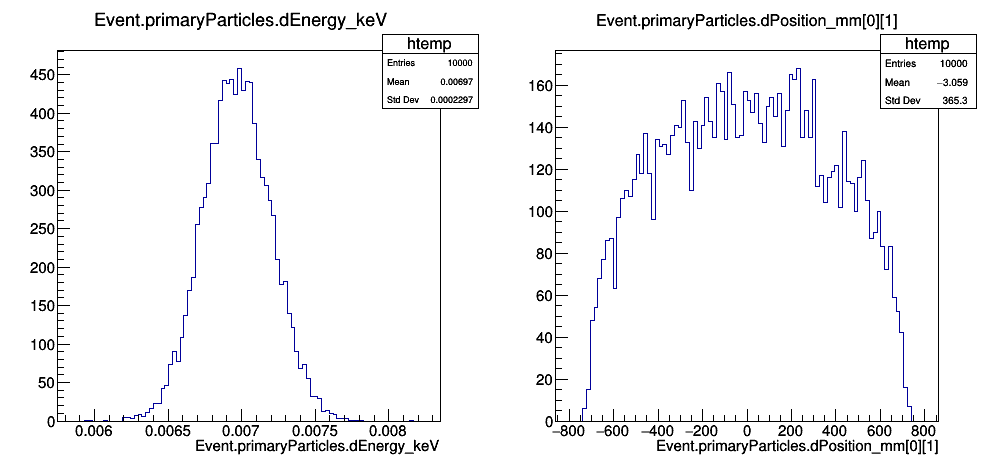

In [14]:
import viewer
hists = ['Event.primaryParticles.dEnergy_keV', 'Event.primaryParticles.dPosition_mm[0][1]']
c = viewer.simple_baccarat_canvas('bacc_outdir/s2photonbomb_42.root', 'DataTree', hists)
c.Draw()

#### TASK
Find out how many of these photons hit PMTs. You will need to look at `Event.tracks.step.iVolumeID`. Example code on doing this can be found [here](https://gitlab.com/seriksen/S2LightMaps/-/blob/master/produceS2HitMaps.cc). Also the next section gives some example on accessing files.

## Electron in Liquid Xenon

Now lets run some simulations where each event will have one electron in it and see what happens.
In this case, we will simulate the S2 photons in BACCARAT still so that we can do some analysis without running `BaccMCTruth`.

In [15]:
%%script env bash

shifter --module=cvmfs --image=luxzeplin/offline_hosted:centos7 /bin/bash
    
macro=macros/electrons.mac
export OUTDIR=bacc_outdir
export NEVENTS=100
export SEED=42
BACCARAT_release=6.0.0
source /cvmfs/lz.opensciencegrid.org/BACCARAT/release-${BACCARAT_release}/x86_64-centos7-gcc8-opt/setup.sh
echo "Running BACCARAT"
BACCARATExecutable ${macro} &> bacc_outdir/electrons.log
echo "Running ROOT Converter"
BaccRootConverter ${OUTDIR}/electrons_${SEED}.bin

Running BACCARAT
Running ROOT Converter
Processing 0 of 100
Processing 10 of 100
Processing 20 of 100
Processing 30 of 100
Processing 40 of 100
Processing 50 of 100
Processing 60 of 100
Processing 70 of 100
Processing 80 of 100
Processing 90 of 100
Done in 1.3 s.


What we can now do is to start looking at the physics which is going on and what we should see.

Specifically, lets look how many optical photons are produced vs. how many thermal electrons are produced. 
Remember, each event starts with an isotroptic electron point source in the TPC releasing 30keV electrons. 
We therefore expect the primary electron (30keV) to interact multiple times - resulting in electrons and photons.

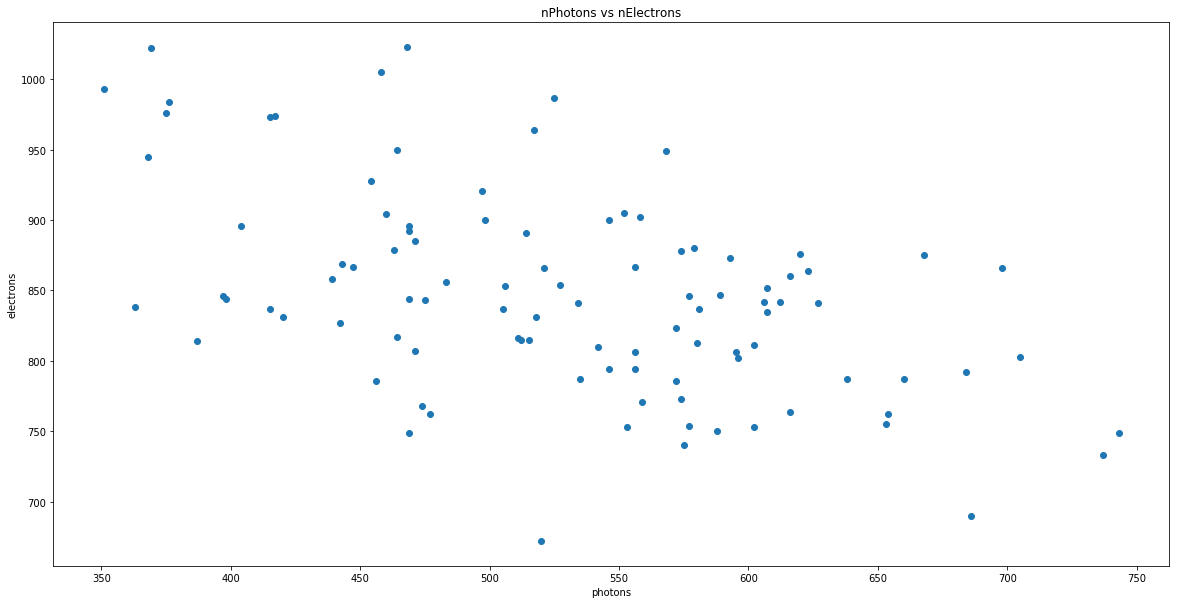

In [17]:
def baccarat_electrons_vs_photons(rfile):
    
    tfile = ROOT.TFile(rfile)
    datatree = tfile.Get('DataTree')
    
    optical = datatree.FindBranch('Event.volumes.iTotalOptPhotNumber')
    therm = datatree.FindBranch('Event.volumes.iTotalThermElecNumber')
    
    n_therm = []
    n_photon = []
    
    length = optical.GetEntryOffsetLen()
    for i in range(optical.GetEntries()):
        optical.GetEntry(i)
        therm.GetEntry(i)
        n_photon.append(optical.GetValue(i,length))
        n_therm.append(therm.GetValue(i, length))   
    fig, ax = plt.subplots(1,1,figsize=(20,10))
    ax.scatter(n_photon, n_therm)
    ax.set_title('nPhotons vs nElectrons')
    ax.set_ylabel('electrons')
    ax.set_xlabel('photons')
    plt.show()
baccarat_electrons_vs_photons('bacc_outdir/electrons_42.root')

### TASK
1. Make a plot of the S1 arrival times.
2. Create a XY scatter map of where the photons ended up.
If I were you, I'd give it a go with uproot rather than pyROOT (as above). For this you will want to install a conda enviroment on NERSC 